## Setup

In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

random = np.random.RandomState()

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_continuous_messages(filepath, proj='pca', return_orig=False):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    npzs = np.load(filepath)
    npzs = {x: npzs[x] for x in npzs.files}

    if proj == 'pca':
        msgs_proj = PCA(2).fit_transform(npzs['msgs'])
    elif proj == 'tsne':
        msgs_proj = TSNE(2).fit_transform(npzs['msgs'])
    else:
        raise ValueError("Unknown projection {}".format(proj))
    
    msgs = pd.DataFrame({
        'x': msgs_proj[:, 1],
        'y': msgs_proj[:, 0],
        'correct': np.all(npzs['preds'] == npzs['obs'], axis=1),
        'relation_dir': npzs['relation_dirs'],
        'relation': npzs['relations'],
        'relation_pair': pd.Series(list(zip(npzs['relation_dirs'], npzs['relations'])))
    })
    if return_orig:
        return msgs, npzs
    else:
        return msgs

def plot2d(msgs, hue='relation_pair'):
    """Plot PCA-reduced messages, colored by relation or other factor"""
    sns.lmplot('x', 'y', data=msgs, fit_reg=False, hue=hue, legend_out=True,
           scatter_kws={'s': 10, 'alpha': 0.3})
    
def load_discrete_messages(filepath):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    npzs = np.load(filepath)
    npzs = {x: npzs[x] for x in npzs.files}
    
    # Must be one-hot
    assert np.all(npzs['msgs'].sum(axis=1) == 1)
    tokens = np.argwhere(npzs['msgs'])[:, 1]

    # Convert one-hot to int tokens
    msgs = pd.DataFrame({
        'tokens': tokens,
        'correct': np.all(npzs['preds'] == npzs['obs'], axis=1),
        'relation_dir': npzs['relation_dirs'],
        'relation': npzs['relations'],
        'relation_pair': pd.Series(list(zip(npzs['relation_dirs'], npzs['relations'])))
    })
    return msgs

## Analysis: Feature model

With a model that gets clean indicators for image features (i.e. the Shapeworld World data), messages show clean relational structure in both continuous and discrete forms:

## Discrete

In [92]:
msgs = load_discrete_messages('data/500_500_asymTrue-end2end-gru-discrete2-30epochs-msgs.npz')
msgs[msgs.tokens == 1]

,correct,relation,relation_dir,relation_pair,tokens
0,False,False,False,"(False, False)",1
1,False,False,False,"(False, False)",1
2,False,False,False,"(False, False)",1
3,False,True,True,"(True, True)",1
4,False,True,False,"(False, True)",1
5,False,True,True,"(True, True)",1
6,False,True,False,"(False, True)",1
7,False,False,True,"(True, False)",1
8,False,False,False,"(False, False)",1
9,True,True,False,"(False, True)",1


# Continuous

Exact accuracy: 0.8116629464285714


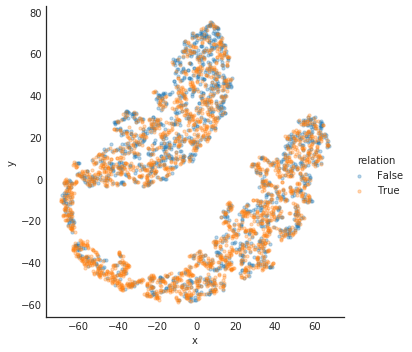

In [105]:
msgs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='tsne')
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

Exact accuracy: 0.8116629464285714


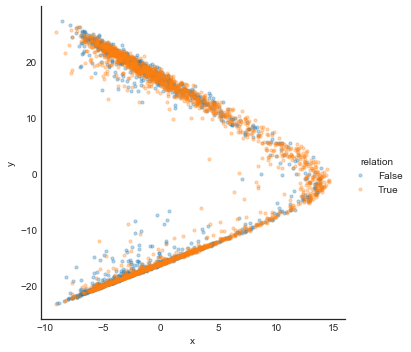

In [3]:
msgs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='pca')
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

In [4]:
msgs, npzs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='pca', return_orig=True)

In [40]:
from collections import Counter
indices_x = Counter()
indices_y = Counter()
# Init all values
for i in range(npzs['msgs'][0].shape[0]):
    indices_x[i] = 0
    indices_y[i] = 0

for msg, rel in zip(npzs['msgs'], npzs['relations']):
    msg_nonzero = np.argwhere(msg).squeeze()
    for i in msg_nonzero:
        if rel == 0:
            indices_x[i] += 1
        else:
            indices_y[i] += 1

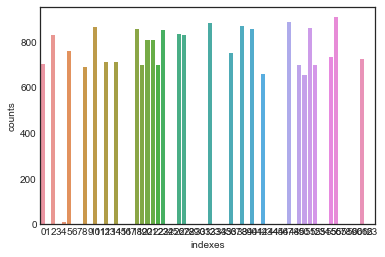

In [43]:
indexes, counts = zip(*indices_x.items())
idx_df = pd.DataFrame({'indexes': indexes, 'counts': counts}).sort_values('indexes')
sns.barplot(idx_df.indexes, idx_df.counts)

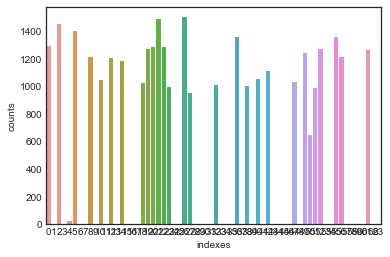

In [44]:
indexes, counts = zip(*indices_y.items())
idx_df = pd.DataFrame({'indexes': indexes, 'counts': counts}).sort_values('indexes')
sns.barplot(idx_df.indexes, idx_df.counts)

In [36]:
len({x: v for x, v in indices.items() if v != 0}.keys())

32

In [65]:
from sklearn.model_selection import train_test_split

data_pairs = list(zip(npzs['msgs'], npzs['relations']))
train, test = train_test_split(data_pairs)
X_train, y_train = zip(*train)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test, y_test = zip(*test)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [66]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [67]:
clf.score(X_test, y_test)

0.6127232142857143

However, this isn't too interesting - we want to explore structure emerging from end-to-end models which have to process raw image data.

# Analysis: End to end models

## Experiment 1: 

The first experiment is an encoder-decoder model with a *continuous* message of dimensionality 128, playing a 3 pick 2 game. We find that messages encode no compositional structure, and thus generalize very poorly. Interestingly, depending on the tensorflow seed, we get different test accuracies trainin - sometimes 75%, sometimes 37.5%. It seems the nets settle on some local optimum depending on the game configurations it gets, which only happen to work on a certain number of other game configurations.

We can figure out what exactly these communication protocols mean, but that's a bit annoying...so will just move on for now.

In [46]:
msgs = load_discrete_messages('data/500_200-feature-gru-discrete2-25epochs-msgs.npz')
msgs[msgs.tokens == 1].head(20)

,correct,relation,relation_dir,relation_pair,tokens
0,True,False,False,"(False, False)",1
2,True,False,True,"(True, False)",1
3,True,True,False,"(False, True)",1
4,True,True,False,"(False, True)",1
5,True,False,True,"(True, False)",1
6,True,False,False,"(False, False)",1
7,True,False,False,"(False, False)",1
10,True,True,False,"(False, True)",1
11,True,True,True,"(True, True)",1
13,True,False,False,"(False, False)",1


# Computing message predictions for alternative images

In [21]:
import tensorflow as tf
session = tf.Session()

In [22]:
saver = tf.train.Saver()
saver.restore(session, 'saves/data/checkpoint')

ValueError: No variables to save